# Задача №1
## Кластеризация скважин по набору кривых ГИС в пределах целевого пласта.
Понимание литологии недр является важной задачей геофизики. Используя различные электрические измерения, полученные с помощью технологии каротажа скважин, специалисты могут сделать выводы о лежащей в основе геологии породы, такой как литология, пористость и проницаемость.

Алгоритмы машинного обучения обычно применяются для группировки измерений каротажа скважин в отдельные литологические группы. Этот процесс может быть достигнут с использованием алгоритмов обучения.

**Кластеризация данных** — это распространенная форма исследовательского анализа данных (EDA), которая используется для разделения данных на разные группы на основе общих характеристик или свойств. Точки данных, похожие друг на друга, группируются в одном кластере, а разные — в другом кластере.

Мы использовали следующие алгоритмы кластеризации:
1. K-mean;
2. Gausinn Mixture Model;
3. Agglomerative Clustering.

В данной задаче логично работать с объединенным набором данных из csv-файлов - `combined.csv`, потому что в условии задачи необхожимо проводить кластеризацию по набору кривых ГИС. 

### Подготовка данных

In [1]:
# Импорт библиотек
import lasio
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import pandas as pd
import os

# Для кластеризации
from scipy.interpolate import interp1d
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture

from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from minisom import MiniSom

In [2]:
# Загружаем данные из CSV-файла в DataFrame
df = pd.read_csv('combined.csv')
# Выводим первые пять строк DataFrame для предварительного осмотра
df.head()

,WELL,DEPT,SSTVD,Z,NEU,GGKP
0,12,3038.5512,2162.042582,-2162.042582,0.2291,2.47
1,12,3038.7036,2162.154621,-2162.154621,0.2400,2.46
2,12,3038.8560,2162.266661,-2162.266661,0.2126,2.51
3,12,3039.0084,2162.378700,-2162.378700,0.1689,2.49
4,12,3039.1608,2162.490740,-2162.490740,0.1633,2.44


In [3]:
# Подсчет и вывод количества пропущенных значений в каждом столбце
missing_values_count = df.isna().sum()
print("Количество пропущенных значений по столбцам:")
print(missing_values_count)

Количество пропущенных значений по столбцам:
WELL       0
DEPT       0
SSTVD      0
Z          0
NEU      822
GGKP       0
dtype: int64


In [4]:
# Определяем скважины, у которых пропущены значения в колонке NEU
wells_with_missing_NEU = df[df['NEU'].isna()]['WELL'].unique()

# Выводим список скважин с пропущенными значениями в колонке NEU
print("Скважины с пропущенными значениями в колонке NEU:")
print(wells_with_missing_NEU)

Скважины с пропущенными значениями в колонке NEU:
['18' '19' '44' '47' '48']


## Disclaimer!!!
На основе уточнений заказчика, кластеризация скважин будет проводиться с упором на параметр GGKP, представляющий ключевую интересующую кривую ГИС для кластеризации. Приоритет данной кривой обусловлен тем, что значения NEU отсутствуют в ряде скважин: `18`, `19`, `44`, `47`, `48`; что может привести к потере ценных данных и, как следствие, снижению точности кластеризации. 

Такой подход позволит сохранить целостность и актуальность анализа при добавлении новых данных, обеспечивая адекватное изменение характеристик кластеров, включая их количество и форму, в соответствии с поступающей информацией.

Когда мы готовимся к кластеризации данных необходимо проводить нормализацию признаков. Это можно сделать с использованием `StandardScaler`. Этот процесс адаптирует данные так, чтобы каждый признак имел среднее значение равное 0 и стандартное отклонение равное 1. 

Такая нормализация необходима, потому что кластеризация K-means чувствительна к масштабу признаков. Если данные не нормализованы, признаки с более высокими значениями или большим разбросом могут непропорционально влиять на результаты, что приводит к искажению структуры кластеров. Нормализация обеспечивает, что каждый признак вносит равный вклад в процесс кластеризации, повышая точность и объективность результатов анализа.

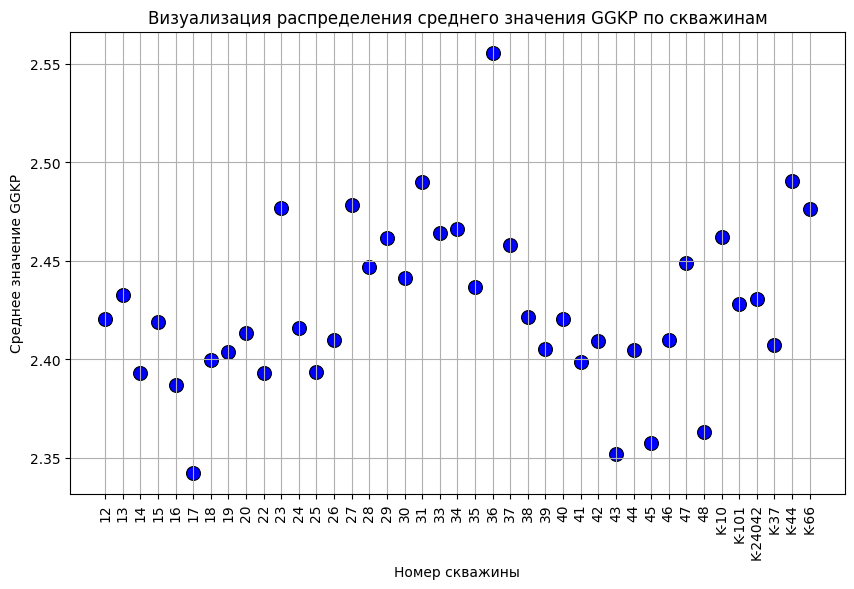

In [5]:
# Агрегация измерений GGKP для каждой скважины для получения средних значений 
agg_data = df.groupby('WELL').agg({'GGKP': 'mean'}).reset_index()

# Выбираем только колонку GGKP, которая будет использоваться как признак для последующей обработки
features_df = agg_data[['GGKP']]

# Применяем стандартизацию к данным
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)

# Создаем диаграмму рассеяния
plt.figure(figsize=(10, 6))
sns.scatterplot(x='WELL', y='GGKP', data=agg_data, s=100, color='blue', edgecolor='k')

plt.title('Визуализация распределения среднего значения GGKP по скважинам')
plt.xlabel('Номер скважины')
plt.ylabel('Среднее значение GGKP')
plt.xticks(rotation=90)  # Поворот меток на оси X для лучшей читаемости
plt.grid(True)  # Включение сетки для удобства восприятия
plt.show()

На основе анализа графика распределения мы наблюдаем, что большая часть значений GGKP сосредоточена в диапазоне от 2.38 до 2.45. Это указывает на то, что в этом интервале находятся наиболее типичные характеристики породы для исследуемой местности. Скважины с GGKP вне этого диапазона могут указывать на необычные геологические условия, которые могут относиться к другим кластерам.

### **Алгоритм KMeans**

Метод локтя — это визуальный способ определения количества кластеров, при котором график "сгибается" или "меняет направление". График строится как зависимость суммы расстояний (инерции) от центров кластеров до каждой точки в датасете от количества кластеров. 

Когда на графике становится видно, на каком значении числа кластеров уменьшение инерции перестаёт быть существенным - это значение и рекомендуется выбирать в качестве оптимального числа кластеров для дальнейшего использования в KMeans.

C:\Users\bonda\miniconda3\envs\rdkit\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bonda\miniconda3\envs\rdkit\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bonda\miniconda3\envs\rdkit\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bonda\miniconda3\envs\rdkit\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

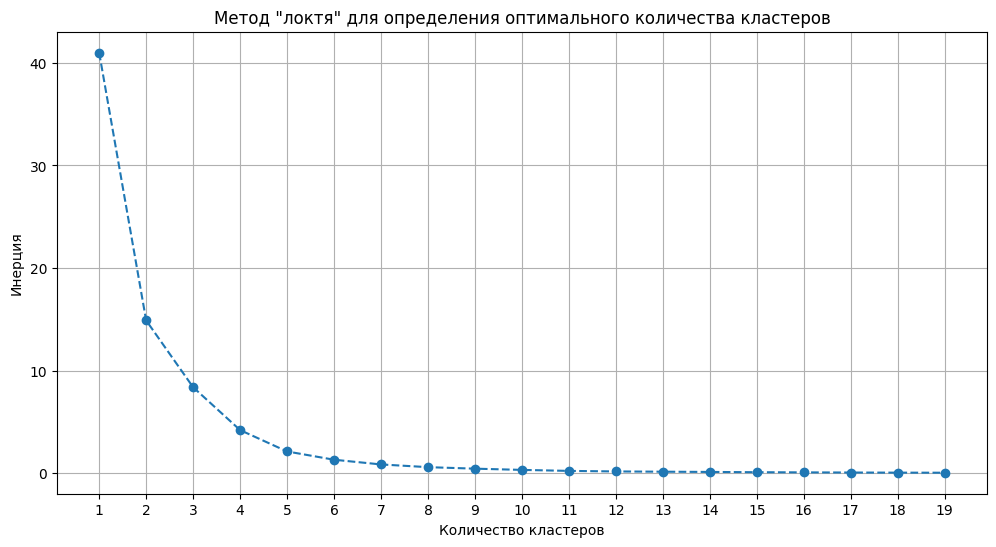

In [6]:
# Установка переменной окружения для предотвращения утечки памяти на Windows с MKL
os.environ['OMP_NUM_THREADS'] = '1'

inertia = []  # Инициализация списка для хранения значения инерции для каждого количества кластеров
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, n_init = 10, random_state=42)  # Создание объекта KMeans с i кластерами
    kmeans.fit(scaled_features)  # Обучение модели на нормализованных данных
    inertia.append(kmeans.inertia_)  # Добавление значения инерции в список

# Построение графика метода "локтя" для определения оптимального числа кластеров
plt.figure(figsize=(12, 6))
plt.plot(range(1, 20), inertia, marker='o', linestyle='--')  # График изменения инерции от количества кластеров
plt.title('Метод "локтя" для определения оптимального количества кластеров')  # Заголовок графика
plt.xlabel('Количество кластеров')  # Подпись оси X
plt.ylabel('Инерция')  # Подпись оси Y
plt.xticks(np.arange(1, 20, step=1))  # Метки на оси X
plt.grid(True)  # Включение сетки на графике
plt.show()  # Отображение графика

График метода "локтя" показывает, что оптимальное количество кластеров для алгоритма KMeans, скорее всего, находится между 3 и 4, так как после этого значения уменьшение инерции становится менее заметным. 

Используем дополнительно метод "силуэта" для оценки качества кластеризации при различном количестве кластеров. Силуэтный анализ дает понимание о том, насколько хорошо объекты были сгруппированы, выраженное через силуэтный коэффициент, где близкие к 1 значения указывают на хорошо разделённые кластеры. 

In [7]:
range_n_clusters = list(range(3,20))  # Создаем список для количества кластеров от 2 до 19

# Перебираем различное количество кластеров для поиска оптимального
for n_clusters in range_n_clusters:
    # Инициализация объекта KMeans с n_clusters кластерами и заданным random_state для воспроизводимости
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    # Производим кластеризацию нормализованных данных и получаем метки кластеров
    cluster_labels = clusterer.fit_predict(scaled_features)

    # Вычисляем средний силуэтный коэффициент для всех объектов, что дает представление о плотности и разделении сформированных кластеров
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    # Выводим среднее значение силуэтного коэффициента для текущего количества кластеров
    print(f"Для n_clusters = {n_clusters}, средний silhouette_score равен: {silhouette_avg}")

Для n_clusters = 3, средний silhouette_score равен: 0.5102183229481957
Для n_clusters = 4, средний silhouette_score равен: 0.558347157030926
Для n_clusters = 5, средний silhouette_score равен: 0.5160463668572266
Для n_clusters = 6, средний silhouette_score равен: 0.49977251828462194
Для n_clusters = 7, средний silhouette_score равен: 0.5430258760580061
Для n_clusters = 8, средний silhouette_score равен: 0.5685479724544272
Для n_clusters = 9, средний silhouette_score равен: 0.6087355703554709
Для n_clusters = 10, средний silhouette_score равен: 0.6464803512013323
Для n_clusters = 11, средний silhouette_score равен: 0.6150925723935476
Для n_clusters = 12, средний silhouette_score равен: 0.5807445256035741
Для n_clusters = 13, средний silhouette_score равен: 0.5598733450932946
Для n_clusters = 14, средний silhouette_score равен: 0.5932387561866951
Для n_clusters = 15, средний silhouette_score равен: 0.6033686614415257
Для n_clusters = 16, средний silhouette_score равен: 0.6023289900301162

C:\Users\bonda\miniconda3\envs\rdkit\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bonda\miniconda3\envs\rdkit\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bonda\miniconda3\envs\rdkit\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bonda\miniconda3\envs\rdkit\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

На основе метода "локтя" и силуэтного анализа, мы наблюдаем, что два кластера предлагают наилучшую степень разделения с наивысшим силуэтным коэффициентом, однако, рассмотрение **четырех кластеров** также может быть оправданным, учитывая сравнительно **высокий силуэтный коэффициент 0.558**. Использование четырех кластеров обеспечивает более детальное разделение данных, что может быть полезно в зависимости от специфики задачи и понимания доменной области. Следовательно, мы определяем четыре кластера как оптимальное количество для использования в алгоритме KMeans, чтобы обеспечить баланс между плотностью кластеров и их различимостью.

После того, как было определено оптимальное количество кластеров, следующим шагом является непосредственно применение алгоритма кластеризации KMeans к данным. Модель KMeans инициализируется с тремя кластерами и затем обучается на нормализованных признаках, чтобы найти центры кластеров и назначить каждому объекту метку соответствующего кластера.

In [8]:
# Инициализация KMeans с четырьмя кластерами
kmeans = KMeans(n_clusters=4, random_state=42)

# Обучение модели кластеризации на нормализованных данных
kmeans.fit(scaled_features)

C:\Users\bonda\miniconda3\envs\rdkit\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

In [9]:
# Присвоение каждой строке метки кластера
agg_data['Cluster_kmean_scaled'] = kmeans.labels_ + 1

agg_data

,WELL,GGKP,Cluster_kmean_scaled
0,12,2.420357,2
1,13,2.432627,1
2,14,2.393182,2
3,15,2.418803,2
4,16,2.387105,2
5,17,2.342452,4
6,18,2.399818,2
7,19,2.403706,2
8,20,2.413209,2
9,22,2.392946,2


Исходный датафрейм `agg_data` содержит информацию о скважинах, а именно столбцы 'WELL' и 'Cluster_kmean_scaled' содержат соответственно номера скважин и присвоенные им номера кластеров после выполнения кластерного анализа **стандартным методом K-means**. 

Мы создадим копию этих данных в новый датафрейм `well_cluster_df`, после чего переименуем столбцы для большей ясности и соответствия заданному формату. Номера кластеров будут преобразованы к целочисленному типу данных для удобства последующей работы. В конце мы выведем таблицу без индексов, чтобы она была чистой и легкой для восприятия.

In [10]:
# 'WELL' это столбец в agg_data с номерами скважин, и 'Cluster_kmean_scaled' это столбец с номерами кластеров
well_cluster_df = agg_data[['WELL', 'Cluster_kmean_scaled']].copy()

# Переименовываем столбцы для соответствия заданному формату
well_cluster_df.columns = ['Номер скважины', 'Номер кластера по стандартному Kmeans']

# Преобразуем номер кластера к целочисленному типу
well_cluster_df['Номер кластера по стандартному Kmeans'] = well_cluster_df['Номер кластера по стандартному Kmeans'].astype(int)

# Выводим отформатированную таблицу
print(well_cluster_df.to_string(index=False))

Номер скважины  Номер кластера по стандартному Kmeans
            12                                      2
            13                                      1
            14                                      2
            15                                      2
            16                                      2
            17                                      4
            18                                      2
            19                                      2
            20                                      2
            22                                      2
            23                                      3
            24                                      2
            25                                      2
            26                                      2
            27                                      3
            28                                      1
            29                                      1
            30              

В следуюзем фрагменте кода мы обработаем результаты кластерного анализа скважин (стандартный Kmeans) и подготавлим данные для визуализации по кластерам: 

После присвоения скважинам меток кластеров, мы организуем информацию в словаре, группируя данные по кластерам. Для каждой скважины собираем данные по глубине (DEPT) и параметру GGKP, чтобы впоследствии вычислить центроид каждого кластера. Центроидом выбирается скважина, чьи значения GGKP наиболее близки к среднему значению по кластеру.

Затем строим ряд графиков (субплотов), по одному на каждый кластер, на которых кривые всех скважин отображаются тонкими серыми линиями, а кривая центроида - выделяется красным жирным цветом. Это позволяет наглядно сравнить характеристики центроида с остальными скважинами в кластере. Графики строятся таким образом, чтобы инвертировать ось Y, что является стандартом для геологических данных.

In [11]:
# Добавляем метки кластеров в agg_data
agg_data['Cluster_kmean_scaled'] = kmeans.labels_ + 1

# Создаем словарь для хранения данных
clusters_dict = {cluster: [] for cluster in agg_data['Cluster_kmean_scaled'].unique()}

# Проходим по каждой строке в agg_data
for _, row in agg_data.iterrows():
    well = row['WELL']
    cluster = row['Cluster_kmean_scaled']
    
    # Получаем все значения DEPT и GGKP для данной скважины из df
    well_data = df[df['WELL'] == well]
    well_dept_list = well_data['DEPT'].tolist()
    well_ggkp_list = well_data['GGKP'].tolist()
    
    # Создаем словарь для текущей скважины с отдельными списками для DEPT и GGKP
    well_dict = {
        'DEPT': well_dept_list,
        'GGKP': well_ggkp_list
    }
    
    # Добавляем словарь скважины в соответствующий список кластера
    clusters_dict[cluster].append({well: well_dict})

# Выводим получившийся словарь
#for cluster, wells_data in clusters_dict.items():
    #print(f"Cluster {cluster}:")
    #for well_dict in wells_data:
        #for well, data in well_dict.items():
            #print(f"  Well {well}:")
            #print(f"    DEPT: {', '.join(map(str, data['DEPT']))}")
            #print(f"    GGKP: {', '.join(map(str, data['GGKP']))}")
    #print("\n")

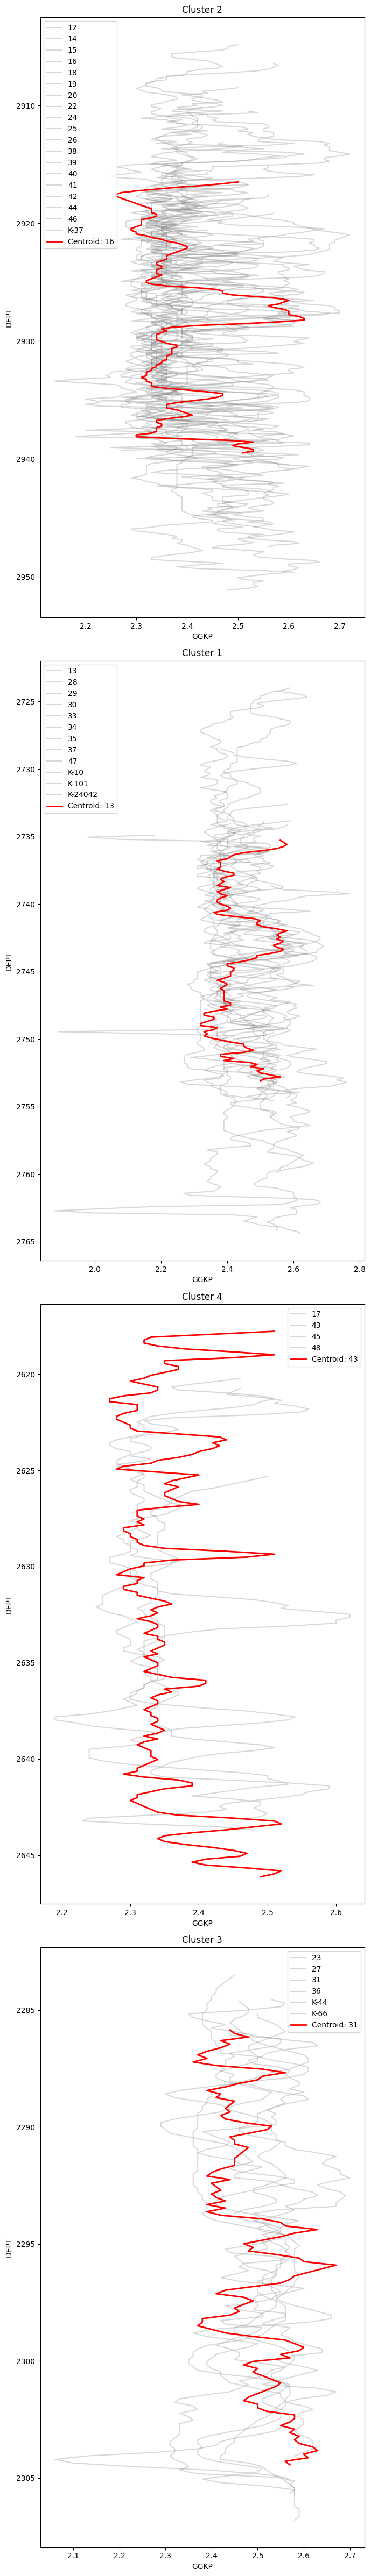

In [12]:
# Функция для вычисления центроида кластера
def calculate_centroid(wells_data):
    all_depts = np.concatenate([list(data['DEPT']) for well_dict in wells_data for data in well_dict.values()])
    return np.mean(all_depts)

# Функция для сдвига DEPT к центроиду кластера
def align_to_centroid(well_data, centroid_dept_value):
    dept_diff = np.mean(well_data['DEPT']) - centroid_dept_value
    well_data['DEPT'] = [dept - dept_diff for dept in well_data['DEPT']]
    return well_data

# Функция для вычисления центроида кластера
def calculate_centroid(wells_data):
    all_depts = []
    all_ggkps = []
    for well_dict in wells_data:
        for data in well_dict.values():
            all_depts.extend(data['DEPT'])
            all_ggkps.extend(data['GGKP'])
    # Определяем скважину-центроид как ту, которая ближе всего к среднему значению DEPT
    centroid_well = min(wells_data, key=lambda wd: np.abs(np.mean(list(wd.values())[0]['DEPT']) - np.mean(all_depts)))
    well_name = list(centroid_well.keys())[0]
    centroid_well_data = list(centroid_well.values())[0]
    return {
        'WELL': well_name,
        'DEPT': centroid_well_data['DEPT'],
        'GGKP': centroid_well_data['GGKP']
    }

# Вычисляем центроиды для каждого кластера
centroids = {cluster: calculate_centroid(wells) for cluster, wells in clusters_dict.items()}

# Создаем субплоты
num_clusters = len(clusters_dict)
fig, axes = plt.subplots(num_clusters, 1, figsize=(7, num_clusters * 12), sharey='row')

if num_clusters == 1:
    axes = [axes]

# Проходим по каждому кластеру и строим графики
for ax, (cluster, wells_data) in zip(axes, clusters_dict.items()):
    # Получаем данные центроида для текущего кластера
    centroid = centroids[cluster]
    # Вычисляем среднее значение DEPT для центроида
    centroid_dept_value = np.mean(centroid['DEPT'])
    
    for well_dict in wells_data:
        for well, data in well_dict.items():
            # Сдвигаем DEPT скважины к центроиду
            aligned_data = align_to_centroid(data, centroid_dept_value)            
            # Рисуем кривую GGKP скважины
            ax.plot(aligned_data['GGKP'], aligned_data['DEPT'], label=well, color='gray', alpha=0.3)

    # Рисуем центроид красным жирным цветом поверх всех остальных
    ax.plot(centroid['GGKP'], centroid['DEPT'], 'r-', linewidth=2, label=f"Centroid: {centroid['WELL']}")
            
    ax.set_title(f'Cluster {cluster}')
    ax.invert_yaxis()  # Для геологических данных обычно ось Y инвертируется
    ax.set_xlabel('GGKP')
    ax.set_ylabel('DEPT')
    ax.legend()

plt.tight_layout()
plt.show()

#### **Алгоритм GMM (Gaussin Mixture Model)**

In [13]:
# Инициализация кластеризации GMM 
gmm = GaussianMixture(n_components=4, random_state=42)

gmm.fit(scaled_features)

C:\Users\bonda\miniconda3\envs\rdkit\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


GaussianMixture(n_components=4, random_state=42)

In [14]:
# Предсказание меток кластеров с помощью обученной модели GMM
agg_data['Cluster_gmm'] = gmm.predict(scaled_features) + 1

# Выведем DataFrame, чтобы увидеть результат
agg_data

,WELL,GGKP,Cluster_kmean_scaled,Cluster_gmm
0,12,2.420357,2,2
1,13,2.432627,1,1
2,14,2.393182,2,2
3,15,2.418803,2,2
4,16,2.387105,2,2
5,17,2.342452,4,4
6,18,2.399818,2,2
7,19,2.403706,2,2
8,20,2.413209,2,2
9,22,2.392946,2,2


In [15]:
# Группировка по скважинам
wells = df.groupby('WELL')

# Определение максимальной длины временного ряда среди всех скважин
max_length = wells['GGKP'].count().max()

# Инициализация списка для входных векторов
input_vectors = []

# Преобразование каждого временного ряда к одинаковой длине
for name, group in wells:
    dept_values = group['GGKP'].values
    # Дополнение или усечение данных
    if len(dept_values) < max_length:
        # Дополнение временного ряда значением np.nan до максимальной длины
        dept_values = np.pad(dept_values, (0, max_length - len(dept_values)), 'constant', constant_values=np.nan)
    elif len(dept_values) > max_length:
        # Усечение временного ряда до максимальной длины
        dept_values = dept_values[:max_length]
    
    # Добавление обработанного временного ряда в список
    input_vectors.append(dept_values)

# Преобразование списка в NumPy массив
input_vectors = np.array(input_vectors)

# Замена np.nan на среднее значение по колонке
col_mean = np.nanmean(input_vectors, axis=0)
inds = np.where(np.isnan(input_vectors))
input_vectors[inds] = np.take(col_mean, inds[1])

In [16]:
well_cluster_df1 = agg_data[['WELL', 'Cluster_gmm']].copy()

# Переименовываем столбцы для соответствия заданному формату
well_cluster_df1.columns = ['Номер скважины', 'Номер кластера по GMM']

# Преобразуем номер кластера к целочисленному типу
well_cluster_df1['Номер кластера по GMM'] = well_cluster_df1['Номер кластера по GMM'].astype(int)

# Выводим отформатированную таблицу
print(well_cluster_df1.to_string(index=False))

Номер скважины  Номер кластера по GMM
            12                      2
            13                      1
            14                      2
            15                      2
            16                      2
            17                      4
            18                      2
            19                      2
            20                      2
            22                      2
            23                      1
            24                      2
            25                      2
            26                      2
            27                      1
            28                      1
            29                      1
            30                      1
            31                      1
            33                      1
            34                      1
            35                      1
            36                      3
            37                      1
            38                      2
            

In [17]:
# Создаем словарь для хранения данных
clusters_dict1 = {cluster: [] for cluster in agg_data['Cluster_gmm'].unique()}

# Проходим по каждой строке в agg_data
for _, row in agg_data.iterrows():
    well = row['WELL']
    cluster = row['Cluster_gmm']
    
    # Получаем все значения DEPT и GGKP для данной скважины из df
    well_data = df[df['WELL'] == well]
    well_dept_list = well_data['DEPT'].tolist()
    well_ggkp_list = well_data['GGKP'].tolist()
    
    # Создаем словарь для текущей скважины с отдельными списками для DEPT и GGKP
    well_dict = {
        'DEPT': well_dept_list,
        'GGKP': well_ggkp_list
    }
    
    # Добавляем словарь скважины в соответствующий список кластера
    clusters_dict1[cluster].append({well: well_dict})

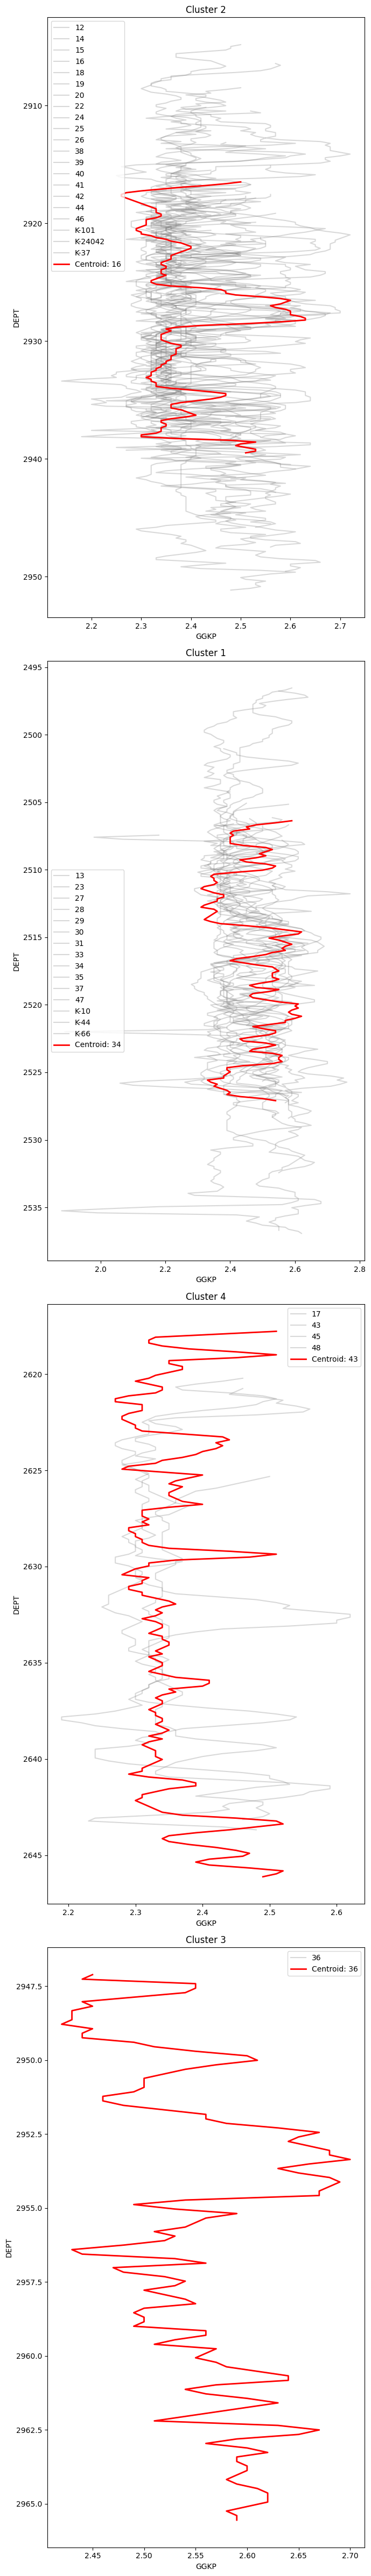

In [18]:
# Функция для вычисления центроида кластера
def calculate_centroid(wells_data):
    all_depts = []
    all_ggkps = []
    for well_dict in wells_data:
        for data in well_dict.values():
            all_depts.extend(data['DEPT'])
            all_ggkps.extend(data['GGKP'])
    centroid_well = min(wells_data, key=lambda wd: np.abs(np.mean(list(wd.values())[0]['DEPT']) - np.mean(all_depts)))
    well_name = list(centroid_well.keys())[0]
    centroid_well_data = list(centroid_well.values())[0]
    return {
        'WELL': well_name,
        'DEPT': centroid_well_data['DEPT'],
        'GGKP': centroid_well_data['GGKP']
    }

# Функция для сдвига DEPT к центроиду кластера
def align_to_centroid(well_data, centroid_dept_value):
    dept_diff = np.mean(well_data['DEPT']) - centroid_dept_value
    well_data['DEPT'] = [dept - dept_diff for dept in well_data['DEPT']]
    return well_data

# Вычисляем центроиды для каждого кластера
centroids = {cluster: calculate_centroid(wells) for cluster, wells in clusters_dict1.items()}

# Создаем субплоты
num_clusters = len(clusters_dict1)
fig, axes = plt.subplots(num_clusters, 1, figsize=(7, num_clusters * 12), sharey='row')
if num_clusters == 1:
    axes = [axes]

# Проходим по каждому кластеру и строим графики
for ax, (cluster, wells_data) in zip(axes, clusters_dict1.items()):
    # Получаем данные центроида для текущего кластера
    centroid = centroids[cluster]
    # Вычисляем среднее значение DEPT для центроида
    centroid_dept_value = np.mean(centroid['DEPT'])
    
    for well_dict in wells_data:
        for well, data in well_dict.items():
            # Сдвигаем DEPT скважины к центроиду
            aligned_data = align_to_centroid(data, centroid_dept_value)            
            # Рисуем кривую GGKP скважины
            ax.plot(aligned_data['GGKP'], aligned_data['DEPT'], label=well, color='gray', alpha=0.3)

    # Рисуем центроид красным жирным цветом поверх всех остальных
    ax.plot(centroid['GGKP'], centroid['DEPT'], 'r-', linewidth=2, label=f"Centroid: {centroid['WELL']}")

    ax.set_title(f'Cluster {cluster}')
    ax.invert_yaxis()  # Для геологических данных обычно ось Y инвертируется
    ax.set_xlabel('GGKP')
    ax.set_ylabel('DEPT')
    ax.legend()

plt.tight_layout()
plt.show()

### **Алгоритм Иерархической кластеризации (agglomerative clustering)**

In [19]:
from sklearn.cluster import AgglomerativeClustering

# Создание объекта модели и указание количества кластеров
model = AgglomerativeClustering(n_clusters=4)

# Обучение модели на данных
clusters = model.fit_predict(scaled_features)

In [20]:
# Предсказание меток кластеров с помощью обученной модели GMM
agg_data['Cluster_agg'] = clusters + 1

# Выведем первые строки DataFrame, чтобы увидеть результат
agg_data

,WELL,GGKP,Cluster_kmean_scaled,Cluster_gmm,Cluster_agg
0,12,2.420357,2,2,2
1,13,2.432627,1,1,1
2,14,2.393182,2,2,2
3,15,2.418803,2,2,2
4,16,2.387105,2,2,2
5,17,2.342452,4,4,3
6,18,2.399818,2,2,2
7,19,2.403706,2,2,2
8,20,2.413209,2,2,2
9,22,2.392946,2,2,2


In [21]:
well_cluster_df2 = agg_data[['WELL', 'Cluster_agg']].copy()

# Переименовываем столбцы для соответствия заданному формату
well_cluster_df2.columns = ['Номер скважины', 'Номер кластера по Иерархической кластеризации']

# Преобразуем номер кластера к целочисленному типу
well_cluster_df2['Номер кластера по Иерархической кластеризации'] = well_cluster_df2['Номер кластера по Иерархической кластеризации'].astype(int)

# Выводим отформатированную таблицу
print(well_cluster_df2.to_string(index=False))

Номер скважины  Номер кластера по Иерархической кластеризации
            12                                              2
            13                                              1
            14                                              2
            15                                              2
            16                                              2
            17                                              3
            18                                              2
            19                                              2
            20                                              2
            22                                              2
            23                                              1
            24                                              2
            25                                              2
            26                                              2
            27                                              1
        

In [22]:
# Создаем словарь для хранения данных
clusters_dict2 = {cluster: [] for cluster in agg_data['Cluster_agg'].unique()}

# Проходим по каждой строке в agg_data
for _, row in agg_data.iterrows():
    well = row['WELL']
    cluster = row['Cluster_agg']
    
    # Получаем все значения DEPT и GGKP для данной скважины из df
    well_data = df[df['WELL'] == well]
    well_dept_list = well_data['DEPT'].tolist()
    well_ggkp_list = well_data['GGKP'].tolist()
    
    # Создаем словарь для текущей скважины с отдельными списками для DEPT и GGKP
    well_dict = {
        'DEPT': well_dept_list,
        'GGKP': well_ggkp_list
    }
    
    # Добавляем словарь скважины в соответствующий список кластера
    clusters_dict2[cluster].append({well: well_dict})

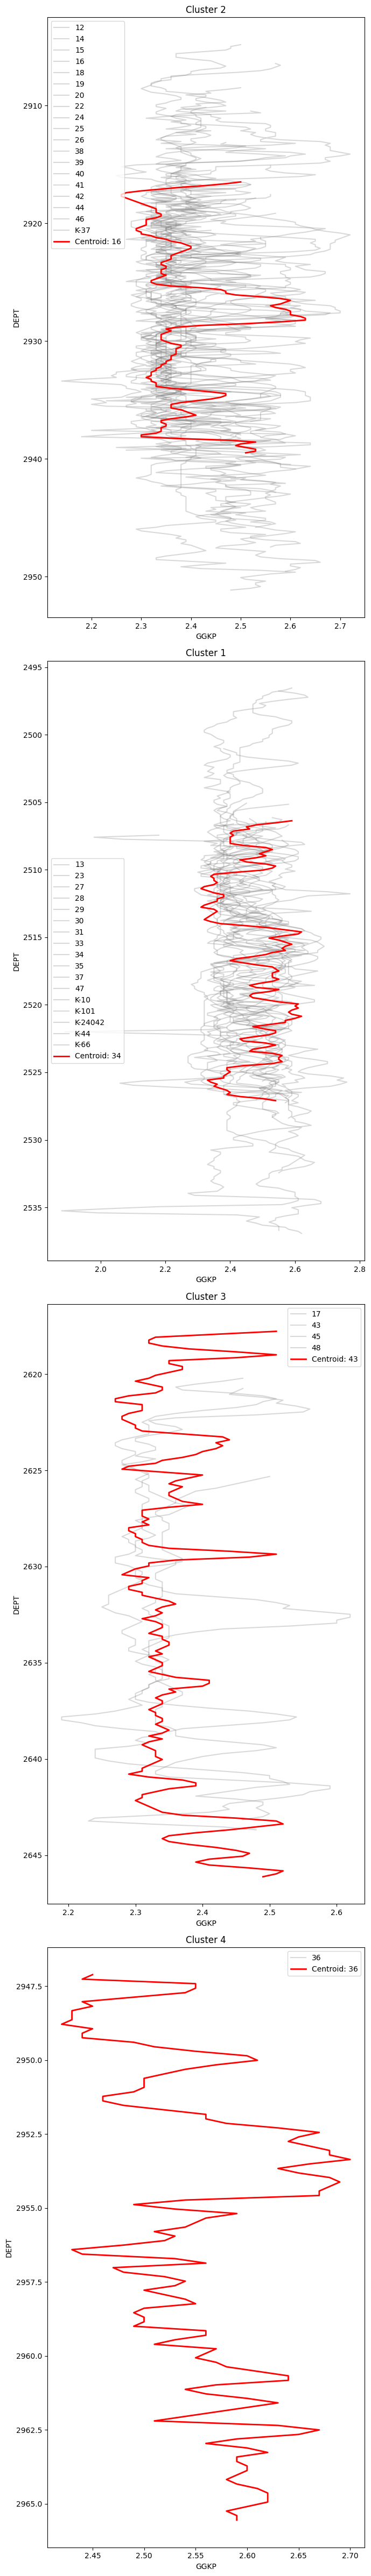

In [23]:
# Функция для вычисления центроида кластера
def calculate_centroid(wells_data):
    all_depts = []
    all_ggkps = []
    for well_dict in wells_data:
        for data in well_dict.values():
            all_depts.extend(data['DEPT'])
            all_ggkps.extend(data['GGKP'])
    centroid_well = min(wells_data, key=lambda wd: np.abs(np.mean(list(wd.values())[0]['DEPT']) - np.mean(all_depts)))
    well_name = list(centroid_well.keys())[0]
    centroid_well_data = list(centroid_well.values())[0]
    return {
        'WELL': well_name,
        'DEPT': centroid_well_data['DEPT'],
        'GGKP': centroid_well_data['GGKP']
    }

# Функция для сдвига DEPT к центроиду кластера
def align_to_centroid(well_data, centroid_dept_value):
    dept_diff = np.mean(well_data['DEPT']) - centroid_dept_value
    well_data['DEPT'] = [dept - dept_diff for dept in well_data['DEPT']]
    return well_data

# Вычисляем центроиды для каждого кластера
centroids = {cluster: calculate_centroid(wells) for cluster, wells in clusters_dict2.items()}

# Создаем субплоты
num_clusters = len(clusters_dict2)
fig, axes = plt.subplots(num_clusters, 1, figsize=(7, num_clusters * 12), sharey='row')
if num_clusters == 1:
    axes = [axes]

# Проходим по каждому кластеру и строим графики
for ax, (cluster, wells_data) in zip(axes, clusters_dict2.items()):
    # Получаем данные центроида для текущего кластера
    centroid = centroids[cluster]
    # Вычисляем среднее значение DEPT для центроида
    centroid_dept_value = np.mean(centroid['DEPT'])
    
    for well_dict in wells_data:
        for well, data in well_dict.items():
            # Сдвигаем DEPT скважины к центроиду
            aligned_data = align_to_centroid(data, centroid_dept_value)            
            # Рисуем кривую GGKP скважины
            ax.plot(aligned_data['GGKP'], aligned_data['DEPT'], label=well, color='gray', alpha=0.3)

    # Рисуем центроид красным жирным цветом поверх всех остальных
    ax.plot(centroid['GGKP'], centroid['DEPT'], 'r-', linewidth=2, label=f"Centroid: {centroid['WELL']}")

    ax.set_title(f'Cluster {cluster}')
    ax.invert_yaxis()  # Для геологических данных обычно ось Y инвертируется
    ax.set_xlabel('GGKP')
    ax.set_ylabel('DEPT')
    ax.legend()

plt.tight_layout()
plt.show()

### **Реализация "Ансамбля" для кластеризаций для выбора лучшего результата**

In [24]:
from collections import Counter
# Определение столбцов, которые содержат результаты кластеризации трех моделей по началу названия колонок
cluster_columns = [col for col in agg_data.columns if col.startswith('Cluster_')]

# Функция для голосования большинства
def majority_voting(row):
    # Получаем значения из столбцов кластеризации
    clusters = row[cluster_columns].tolist()  # используем tolist() для преобразования в список
    # Подсчет элементов и нахождение моды
    most_common = Counter(clusters).most_common(1)
    return most_common[0][0]

# Применяем функцию к каждой строке DataFrame
agg_data['Cluster_result'] = agg_data.apply(majority_voting, axis=1)

# Вывод обновленного DataFrame
agg_data

,WELL,GGKP,Cluster_kmean_scaled,Cluster_gmm,Cluster_agg,Cluster_result
0,12,2.420357,2,2,2,2
1,13,2.432627,1,1,1,1
2,14,2.393182,2,2,2,2
3,15,2.418803,2,2,2,2
4,16,2.387105,2,2,2,2
5,17,2.342452,4,4,3,4
6,18,2.399818,2,2,2,2
7,19,2.403706,2,2,2,2
8,20,2.413209,2,2,2,2
9,22,2.392946,2,2,2,2


In [25]:
well_cluster_df3 = agg_data[['WELL', 'Cluster_result']].copy()

well_cluster_df3.columns = ['Номер скважины', 'Результирующий номер кластера']

# Преобразуем номер кластера к целочисленному типу
well_cluster_df3['Результирующий номер кластера'] = well_cluster_df3['Результирующий номер кластера'].astype(int)

# Выводим отформатированную таблицу
print(well_cluster_df3.to_string(index=False))

Номер скважины  Результирующий номер кластера
            12                              2
            13                              1
            14                              2
            15                              2
            16                              2
            17                              4
            18                              2
            19                              2
            20                              2
            22                              2
            23                              1
            24                              2
            25                              2
            26                              2
            27                              1
            28                              1
            29                              1
            30                              1
            31                              1
            33                              1
            34                    

In [26]:
# Создаем словарь для хранения данных
clusters_dict3 = {cluster: [] for cluster in agg_data['Cluster_agg'].unique()}

# Проходим по каждой строке в agg_data
for _, row in agg_data.iterrows():
    well = row['WELL']
    cluster = row['Cluster_agg']
    
    # Получаем все значения DEPT и GGKP для данной скважины из df
    well_data = df[df['WELL'] == well]
    well_dept_list = well_data['DEPT'].tolist()
    well_ggkp_list = well_data['GGKP'].tolist()
    
    # Создаем словарь для текущей скважины с отдельными списками для DEPT и GGKP
    well_dict = {
        'DEPT': well_dept_list,
        'GGKP': well_ggkp_list
    }
    
    # Добавляем словарь скважины в соответствующий список кластера
    clusters_dict3[cluster].append({well: well_dict})

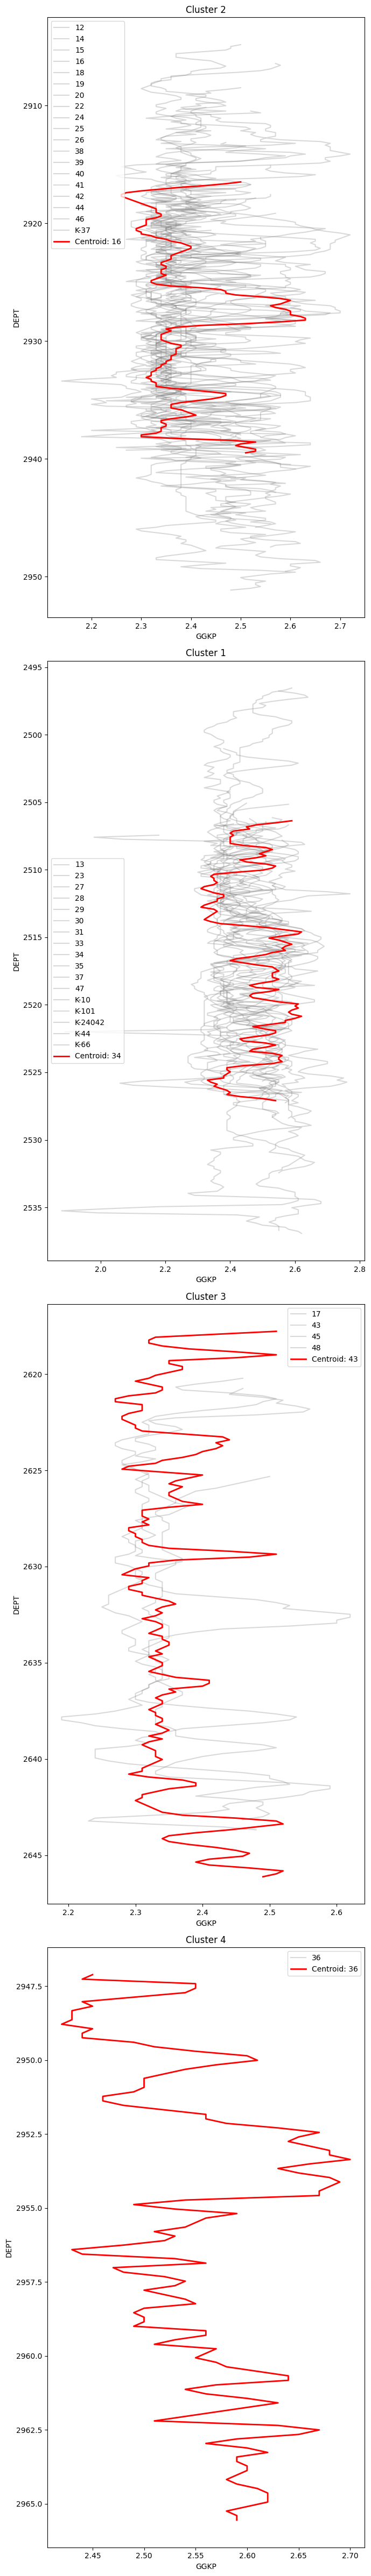

In [27]:
# Функция для вычисления центроида кластера
def calculate_centroid(wells_data):
    all_depts = []
    all_ggkps = []
    for well_dict in wells_data:
        for data in well_dict.values():
            all_depts.extend(data['DEPT'])
            all_ggkps.extend(data['GGKP'])
    centroid_well = min(wells_data, key=lambda wd: np.abs(np.mean(list(wd.values())[0]['DEPT']) - np.mean(all_depts)))
    well_name = list(centroid_well.keys())[0]
    centroid_well_data = list(centroid_well.values())[0]
    return {
        'WELL': well_name,
        'DEPT': centroid_well_data['DEPT'],
        'GGKP': centroid_well_data['GGKP']
    }

# Функция для сдвига DEPT к центроиду кластера
def align_to_centroid(well_data, centroid_dept_value):
    dept_diff = np.mean(well_data['DEPT']) - centroid_dept_value
    well_data['DEPT'] = [dept - dept_diff for dept in well_data['DEPT']]
    return well_data

# Вычисляем центроиды для каждого кластера
centroids = {cluster: calculate_centroid(wells) for cluster, wells in clusters_dict3.items()}

# Создаем субплоты
num_clusters = len(clusters_dict3)
fig, axes = plt.subplots(num_clusters, 1, figsize=(7, num_clusters * 12), sharey='row')
if num_clusters == 1:
    axes = [axes]

# Проходим по каждому кластеру и строим графики
for ax, (cluster, wells_data) in zip(axes, clusters_dict3.items()):
    # Получаем данные центроида для текущего кластера
    centroid = centroids[cluster]
    # Вычисляем среднее значение DEPT для центроида
    centroid_dept_value = np.mean(centroid['DEPT'])
    
    for well_dict in wells_data:
        for well, data in well_dict.items():
            # Сдвигаем DEPT скважины к центроиду
            aligned_data = align_to_centroid(data, centroid_dept_value)            
            # Рисуем кривую GGKP скважины
            ax.plot(aligned_data['GGKP'], aligned_data['DEPT'], label=well, color='gray', alpha=0.3)

    # Рисуем центроид красным жирным цветом поверх всех остальных
    ax.plot(centroid['GGKP'], centroid['DEPT'], 'r-', linewidth=2, label=f"Centroid: {centroid['WELL']}")

    ax.set_title(f'Cluster {cluster}')
    ax.invert_yaxis()  # Для геологических данных обычно ось Y инвертируется
    ax.set_xlabel('GGKP')
    ax.set_ylabel('DEPT')
    ax.legend()

plt.tight_layout()
plt.show()